In [3]:
import os
import math
import random
from pathlib import Path
from typing import Dict, List, Tuple
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from skimage.morphology import remove_small_objects, binary_opening, binary_closing, disk
from skimage.measure import label, regionprops
from skimage.measure import label as sk_label

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix,roc_curve, auc, precision_recall_curve, f1_score
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import joblib
from sklearn.metrics import accuracy_score, f1_score
import numpy as np


import joblib

# Reproducibility 
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Fixed resize scale 
FIXED_SCALE = 0.80

DATA_ROOT = r"C:\BPA\data"

CLASS_MAP = {
    "Gunshot": "gunshot",
    "Impact": "impact",
}


OUTPUT_DIR = r"C:\BPA\final\model"
os.makedirs(OUTPUT_DIR, exist_ok=True)


FEATURE_OUTPUT_DIR = r"C:\BPA\final\model"
os.makedirs(FEATURE_OUTPUT_DIR, exist_ok=True)

FEATURE_CSV = os.path.join(FEATURE_OUTPUT_DIR, "features_coated.csv")
MODEL_BUNDLE_PATH = os.path.join(OUTPUT_DIR, "model_bundle_expert.pkl")

print(f"  DATA_ROOT        = {DATA_ROOT}")
print(f"  OUTPUT_DIR       = {OUTPUT_DIR}")
print(f"  FEATURE_CSV      = {FEATURE_CSV}")
print(f"  MODEL_BUNDLE_PATH= {MODEL_BUNDLE_PATH}")
print(f"  FIXED_SCALE      = {FIXED_SCALE}")


  DATA_ROOT        = C:\BPA\data
  OUTPUT_DIR       = C:\BPA\final\model
  FEATURE_CSV      = C:\BPA\final\model\features_coated.csv
  MODEL_BUNDLE_PATH= C:\BPA\final\model\model_bundle_expert.pkl
  FIXED_SCALE      = 0.8


IMAGE LOADER

In [4]:
Image.MAX_IMAGE_PIXELS = None 

MAX_SIDE = 10000
MAX_PIX  = 70_000_000

def load_image_bgr(path: str) -> np.ndarray:
    """Load image as BGR, with robust fallbacks."""
    img = None
    try:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    except cv2.error as e:
        print(f" OpenCV error on {path}: {e}")
        img = None

    if img is not None:
        # PNG with alpha
        if len(img.shape) == 3 and img.shape[2] == 4:
            alpha = img[:, :, 3] / 255.0
            rgb = img[:, :, :3].astype(np.float32)

            rgb = np.where(
                alpha[..., None] > 0,
                rgb / np.maximum(alpha[..., None], 1e-5),
                rgb,
            )

            rgb = np.clip(rgb, 0, 255).astype(np.uint8)
            img_bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
            return img_bgr

        return img

    # Fallback to PIL
    print(f" OpenCV could not load {path}. Using PIL")
    try:
        pil_img = Image.open(path)
    except Exception as e:
        print(f"PIL also failed to open {path}: {e}")
        return None

    if pil_img.mode in ("RGBA", "LA"):
        pil_img = pil_img.convert("RGBA")
    else:
        pil_img = pil_img.convert("RGB")

    w, h = pil_img.size

    MAX_ORIG_SIDE = 25000
    MAX_ORIG_PIX  = 120_000_000

    if (w * h > MAX_ORIG_PIX) or (max(w, h) > MAX_ORIG_SIDE):
        factor_pix  = math.sqrt(MAX_ORIG_PIX / float(w * h))
        factor_side = MAX_ORIG_SIDE / float(max(w, h))
        factor = min(factor_pix, factor_side, 1.0)

        new_w = max(1, int(round(w * factor)))
        new_h = max(1, int(round(h * factor)))
        print(f"[WARN] PIL downscaling huge image at load time: {w}x{h} -> {new_w}x{new_h}")
        pil_img = pil_img.resize((new_w, new_h), Image.BILINEAR)
        w, h = new_w, new_h

    arr = np.array(pil_img)

    if arr.ndim == 3 and arr.shape[2] == 4:
        rgb = arr[:, :, :3].astype(np.uint8)
        bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    elif arr.ndim == 3 and arr.shape[2] == 3:
        bgr = cv2.cvtColor(arr.astype(np.uint8), cv2.COLOR_RGB2BGR)
    else:
        gray = arr.astype(np.uint8)
        bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    return bgr


def resize_fixed_scale(img: np.ndarray, base_scale: float = FIXED_SCALE) -> Tuple[np.ndarray, float]:
    """
    Resize image by base scale (0.80) AND apply an adaptive downscale
    only if the scaled image is still too large.
    Returns: resized_img, final_scale
    """
    h, w = img.shape[:2]
    if h == 0 or w == 0:
        raise ValueError("resize_fixed_scale: empty image.")

    scale = base_scale
    new_h = int(round(h * scale))
    new_w = int(round(w * scale))

    if (new_h * new_w > MAX_PIX) or (max(new_h, new_w) > MAX_SIDE):
        factor_pix  = math.sqrt(MAX_PIX / float(new_h * new_w))
        factor_side = MAX_SIDE / float(max(new_h, new_w))
        extra = min(factor_pix, factor_side, 1.0)

        scale *= extra
        new_h = max(1, int(round(h * scale)))
        new_w = max(1, int(round(w * scale)))

        print(" Image too large after base scale so extra downscale applied.")
        print(f" final scale = {scale:.4f}, final size = {new_w} x {new_h}")

    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return resized, scale

print("Image loader and resize helper ready.")


Image loader and resize helper ready.


SEGMENTATION HSV + RED DOMINANCE + COATING MASK

In [5]:
def _segment_blood_binary(img_bgr_resized: np.ndarray) -> np.ndarray:
    
    # Returns a boolean mask of blood pixels that are used as a feature to build highlight/coated images.
    
    if img_bgr_resized is None or img_bgr_resized.size == 0:
        raise ValueError("_segment_blood_binary: empty image")

    # RGB red dominance
    b, g, r = cv2.split(img_bgr_resized)
    r_i = r.astype(np.int32)
    g_i = g.astype(np.int32)
    b_i = b.astype(np.int32)

    red_dom = (
        (r_i > g_i + 10) &
        (r_i > b_i + 10) &
        (r >= 40)
    )

    # HSV red bands
    hsv = cv2.cvtColor(img_bgr_resized, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lower1 = np.array([0,   15,  15], dtype=np.uint8)
    upper1 = np.array([12, 255, 255], dtype=np.uint8)
    lower2 = np.array([160, 15,  15], dtype=np.uint8)
    upper2 = np.array([179, 255, 255], dtype=np.uint8)

    mask_red1 = cv2.inRange(hsv, lower1, upper1)
    mask_red2 = cv2.inRange(hsv, lower2, upper2)
    base_hsv  = (mask_red1 > 0) | (mask_red2 > 0)

    base_mask = base_hsv & red_dom & (v >= 30)

    if not base_mask.any():
        return np.zeros(img_bgr_resized.shape[:2], dtype=bool)

    cleaned = remove_small_objects(base_mask, min_size=3)
    cleaned = binary_opening(cleaned, disk(1))

    if not cleaned.any():
        cleaned = base_mask

    return cleaned.astype(bool)


def make_highlight_and_coated(img_bgr_resized: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    From a resized image:
      - segment blood
      - build highlight (white background + original colour)
      - build coated grayscale mask (0 background, grayscale intensity for blood)
    """
    mask_bool = _segment_blood_binary(img_bgr_resized)

    # highlight image
    highlight = np.full_like(img_bgr_resized, 255, dtype=np.uint8)
    highlight[mask_bool] = img_bgr_resized[mask_bool]

    # coated grayscale mask
    gray = cv2.cvtColor(img_bgr_resized, cv2.COLOR_BGR2GRAY)
    coated_gray = np.zeros_like(gray, dtype=np.uint8)
    coated_gray[mask_bool] = gray[mask_bool]

    return highlight, coated_gray


def _keep_only_small_components(mask_bool: np.ndarray, max_area: int = 200) -> np.ndarray:
    """
    Keeps ONLY connected components whose area <= max_area (in pixels).
    mask_bool: boolean mask of candidate blood pixels.
    Returns mask with only small components.
    """
    if not mask_bool.any():
        return mask_bool

    lbl = label(mask_bool, connectivity=2)
    small_mask = np.zeros_like(mask_bool, dtype=bool)

    for region in regionprops(lbl):
        if region.area <= max_area:
            small_mask[lbl == region.label] = True

    return small_mask


def _segment_blood_binary_contingency(img_bgr_resized: np.ndarray,
                                      max_small_area: int = 200) -> np.ndarray:
    """
    Softer segmentation for contingency:
      - looser red dominance
      - allows darker stains
      - slightly more morphological cleanup/fill
      - THEN keeps ONLY *small* components (tiny droplets)
    Returns a mask.
    """
    if img_bgr_resized is None or img_bgr_resized.size == 0:
        raise ValueError("_segment_blood_binary_contingency: empty image")

    b, g, r = cv2.split(img_bgr_resized)
    r_i = r.astype(np.int32)
    g_i = g.astype(np.int32)
    b_i = b.astype(np.int32)

    # softer red dominance, accepts weaker and darker reds 
    red_dom = (
        (r_i > g_i + 5) &
        (r_i > b_i + 5) &
        (r >= 25)           
    )

    hsv = cv2.cvtColor(img_bgr_resized, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    # slightly wider HSV bands + lower S/V thresholds
    lower1 = np.array([0,   10,  10], dtype=np.uint8)
    upper1 = np.array([15, 255, 255], dtype=np.uint8)
    lower2 = np.array([160, 10,  10], dtype=np.uint8)
    upper2 = np.array([179, 255, 255], dtype=np.uint8)

    mask_red1 = cv2.inRange(hsv, lower1, upper1)
    mask_red2 = cv2.inRange(hsv, lower2, upper2)
    base_hsv  = (mask_red1 > 0) | (mask_red2 > 0)

    base_mask = base_hsv & red_dom & (v >= 15)

    if not base_mask.any():
        return np.zeros(img_bgr_resized.shape[:2], dtype=bool)

    # allow smaller specks, then lightly close to fill gaps
    cleaned = remove_small_objects(base_mask, min_size=2)
    cleaned = binary_opening(cleaned, disk(1))
    cleaned = binary_closing(cleaned, disk(1))

    if not cleaned.any():
        cleaned = base_mask

    # keeping only small connected components (tiny droplets)
    small_only = _keep_only_small_components(cleaned.astype(bool),
                                              max_area=max_small_area)

    return small_only.astype(bool)


def make_highlight_and_coated_contingency(img_bgr_resized: np.ndarray,
                                          max_small_area: int = 200) -> Tuple[np.ndarray, np.ndarray]:
    """
    Contingency version:
      - uses softer segmentation (_segment_blood_binary_contingency)
      - keeps only *small* stains (micro-mist / tiny droplets)
      - returns highlight + coated grayscale mask
    """
    mask_bool = _segment_blood_binary_contingency(img_bgr_resized,
                                                  max_small_area=max_small_area)

    # highlight image (white background)
    highlight = np.full_like(img_bgr_resized, 255, dtype=np.uint8)
    highlight[mask_bool] = img_bgr_resized[mask_bool]

    # coated grayscale mask
    gray = cv2.cvtColor(img_bgr_resized, cv2.COLOR_BGR2GRAY)
    coat = np.zeros_like(gray, dtype=np.uint8)
    coat[mask_bool] = gray[mask_bool]

    return highlight, coat


FEATURE EXTRACTION USING ONLY COATED MASK

In [6]:
def extract_expert_features_coated(coated_gray: np.ndarray,
                                   img_shape: Tuple[int, int]) -> Dict[str, float]:
  
    H, W = img_shape[:2]
    if coated_gray is None or coated_gray.size == 0:
        raise ValueError("extract_expert_features_coated: empty coated mask")

    blood_mask = coated_gray > 0
    blood_pixels = int(blood_mask.sum())
    total_pixels = int(H * W)

    feats: Dict[str, float] = {}

    # basic coverage 
    feats["blood_pixels"] = float(blood_pixels)
    feats["blood_coverage"] = float(blood_pixels / total_pixels) if total_pixels > 0 else 0.0

    # template for zeros if no blood
    empty_common = {
        "total_stains": 0.0,
        "stains_per_Mpx": 0.0,
        "mean_area": 0.0,
        "median_area": 0.0,
        "std_area": 0.0,
        "max_area": 0.0,
        "dominant_ratio": 0.0,
        "top3_ratio": 0.0,
        "frac_small": 0.0,
        "frac_large": 0.0,
        "num_passive_like": 0.0,
        "frac_passive_like": 0.0,
        "dist_mean_norm": 0.0,
        "dist_std_norm": 0.0,
        "outer_pixel_frac": 0.0,
        "outer_inner_density_ratio": 0.0,
        "mean_aspect_small": 0.0,
        "mean_aspect_large": 0.0,
        "frac_elongated_small": 0.0,
        "frac_elongated_all": 0.0,
        "nn_mean_norm": 0.0,
        "nn_std_norm": 0.0,
        # intensity / mist / core / radial
        "int_mean": 0.0,
        "int_std": 0.0,
        "int_min": 0.0,
        "int_max": 0.0,
        "int_median": 0.0,
        "int_p10": 0.0,
        "int_p90": 0.0,
        "int_cv": 0.0,
        "int_entropy": 0.0,
        "mist_frac_pixels": 0.0,
        "dark_core_frac_pixels": 0.0,
        "dist_mean_intw": 0.0,
        "dist_std_intw": 0.0,
        "r50_norm": 0.0,
        "r90_norm": 0.0,
        "radial_density_slope": 0.0,
        "elong_orientation_std_deg": 0.0,
        "elong_outer_frac": 0.0,
    }

    if blood_pixels == 0:
        feats.update(empty_common)
        return feats

    # INTENSITY STATS 
    vals = coated_gray[blood_mask].astype(np.float32)
    int_mean = float(vals.mean())
    int_std  = float(vals.std())
    int_min  = float(vals.min())
    int_max  = float(vals.max())
    int_med  = float(np.median(vals))
    p10      = float(np.percentile(vals, 10))
    p30      = float(np.percentile(vals, 30))
    p70      = float(np.percentile(vals, 70))
    p90      = float(np.percentile(vals, 90))
    cv       = float(int_std / (int_mean + 1e-6))

    hist, _ = np.histogram(vals, bins=32, range=(0, 255), density=True)
    hist_nz = hist[hist > 0]
    entropy = float(-np.sum(hist_nz * np.log2(hist_nz)))

    feats["int_mean"]    = int_mean
    feats["int_std"]     = int_std
    feats["int_min"]     = int_min
    feats["int_max"]     = int_max
    feats["int_median"]  = int_med
    feats["int_p10"]     = p10
    feats["int_p90"]     = p90
    feats["int_cv"]      = cv
    feats["int_entropy"] = entropy

    feats["mist_frac_pixels"]      = float((vals <= p30).sum() / vals.size)
    feats["dark_core_frac_pixels"] = float((vals >= p70).sum() / vals.size)

    # REGION PROPS 
    labels = sk_label(blood_mask)
    regions = regionprops(labels)
    stains = [r for r in regions if r.area >= 5]
    total_stains = len(stains)
    feats["total_stains"] = float(total_stains)

    if total_stains == 0:
        feats.update(empty_common)
        return feats

    areas = np.array([r.area for r in stains], dtype=float)
    perims = np.array([r.perimeter if r.perimeter > 0 else np.nan for r in stains], dtype=float)
    major_axes = np.array([getattr(r, "major_axis_length", 0.0) for r in stains], dtype=float)
    minor_axes = np.array([getattr(r, "minor_axis_length", 0.0) for r in stains], dtype=float)

    total_blood_area = float(areas.sum())
    max_area = float(areas.max())
    feats["mean_area"] = float(areas.mean())
    feats["median_area"] = float(np.median(areas))
    feats["std_area"] = float(areas.std())
    feats["max_area"] = max_area

    feats["stains_per_Mpx"] = float(total_stains / (total_pixels / 1e6))
    feats["dominant_ratio"] = float(max_area / total_blood_area) if total_blood_area > 0 else 0.0

    sorted_areas = np.sort(areas)[::-1]
    top3 = sorted_areas[:3].sum()
    feats["top3_ratio"] = float(top3 / total_blood_area) if total_blood_area > 0 else 0.0

    q1 = float(np.percentile(areas, 25))
    q3 = float(np.percentile(areas, 75))
    frac_small = float((areas <= q1).sum() / total_stains)
    frac_large = float((areas >= q3).sum() / total_stains)
    feats["frac_small"] = frac_small
    feats["frac_large"] = frac_large

    # passive-like
    num_passive_like = 0
    for a, maj, min_ax, per in zip(areas, major_axes, minor_axes, perims):
        if a < feats["median_area"]:
            continue
        if maj <= 0 or min_ax <= 0 or math.isnan(per) or per <= 0:
            continue
        aspect_ratio = min_ax / maj
        circularity = 4.0 * math.pi * a / (per * per)
        if aspect_ratio >= 0.8 and circularity >= 0.7:
            num_passive_like += 1
    feats["num_passive_like"] = float(num_passive_like)
    feats["frac_passive_like"] = float(num_passive_like / total_stains)

    # SPATIAL SPREAD & RADIAL 
    ys, xs = np.nonzero(blood_mask)
    cy, cx = ys.mean(), xs.mean()
    dists = np.sqrt((ys - cy) ** 2 + (xs - cx) ** 2)
    diag = math.sqrt(H * H + W * W)
    d_norm = dists / diag

    feats["dist_mean_norm"] = float(d_norm.mean())
    feats["dist_std_norm"] = float(d_norm.std())

    # intensity-weighted radius
    w = vals / 255.0
    wsum = float(w.sum()) + 1e-6
    mean_intw = float((d_norm * w).sum() / wsum)
    var_intw = float(((d_norm - mean_intw) ** 2 * w).sum() / wsum)
    feats["dist_mean_intw"] = mean_intw
    feats["dist_std_intw"] = math.sqrt(max(var_intw, 0.0))

    feats["r50_norm"] = float(np.quantile(d_norm, 0.5))
    feats["r90_norm"] = float(np.quantile(d_norm, 0.9))

    # radial density slope (log density vs radius)
    n_bins = 8
    r_bins = np.linspace(0.0, d_norm.max() + 1e-6, n_bins + 1)
    counts, _ = np.histogram(d_norm, bins=r_bins)
    r_mid = 0.5 * (r_bins[:-1] + r_bins[1:])
    areas_ann = (r_bins[1:]**2 - r_bins[:-1]**2) * math.pi
    dens = counts / (areas_ann + 1e-6)
    valid = dens > 0
    if valid.sum() >= 2:
        logd = np.log(dens[valid])
        slope, _ = np.polyfit(r_mid[valid], logd, 1)
        feats["radial_density_slope"] = float(slope)
    else:
        feats["radial_density_slope"] = 0.0

    core_r = 0.08
    outer_r = 0.35
    core_mask = d_norm <= core_r
    outer_mask = (d_norm > core_r) & (d_norm <= outer_r)
    total_pix = float(len(d_norm))
    core_pix = float(core_mask.sum())
    outer_pix = float(outer_mask.sum())
    feats["outer_pixel_frac"] = float(outer_pix / total_pix) if total_pix > 0 else 0.0

    core_area = math.pi * (core_r * diag) ** 2
    ring_area = math.pi * (outer_r * diag) ** 2 - core_area
    if core_area <= 0 or ring_area <= 0:
        feats["outer_inner_density_ratio"] = 0.0
    else:
        core_density = core_pix / core_area
        outer_density = outer_pix / ring_area
        feats["outer_inner_density_ratio"] = float(
            outer_density / core_density if core_density > 0 else 0.0
        )

    # MICROTEXTURE & ORIENTATION 
    aspects = np.zeros_like(areas, dtype=float)
    for i, (maj, min_ax) in enumerate(zip(major_axes, minor_axes)):
        aspects[i] = (min_ax / maj) if maj > 0 else 0.0

    elongated_mask = aspects <= 0.6
    small_mask = areas <= q1
    large_mask = areas >= q3

    feats["mean_aspect_small"] = float(aspects[small_mask].mean()) if small_mask.any() else 0.0
    feats["mean_aspect_large"] = float(aspects[large_mask].mean()) if large_mask.any() else 0.0

    if small_mask.any():
        feats["frac_elongated_small"] = float((elongated_mask & small_mask).sum() / small_mask.sum())
    else:
        feats["frac_elongated_small"] = 0.0
    feats["frac_elongated_all"] = float(elongated_mask.sum() / float(total_stains))

    elong_regions = [r for r, el in zip(stains, elongated_mask) if el]
    if len(elong_regions) > 0:
        ori = np.array([reg.orientation for reg in elong_regions], dtype=float)
        ori_deg = np.rad2deg(ori)
        feats["elong_orientation_std_deg"] = float(abs(ori_deg).std())
    else:
        feats["elong_orientation_std_deg"] = 0.0

    # elongations in outer region
    coords = np.array([r.centroid for r in stains], dtype=float)
    cy_s, cx_s = coords.mean(axis=0)
    d_stain = np.sqrt((coords[:, 0] - cy_s) ** 2 + (coords[:, 1] - cx_s) ** 2)
    d_stain_norm = d_stain / diag
    outer_stain_mask = d_stain_norm > 0.15
    if outer_stain_mask.any():
        feats["elong_outer_frac"] = float((elongated_mask & outer_stain_mask).sum()
                                          / outer_stain_mask.sum())
    else:
        feats["elong_outer_frac"] = 0.0

    # CLUSTERING (NN) 
    total_stains = len(stains)
    if total_stains > 1:
        MAX_NN_POINTS = 4000
        if total_stains <= MAX_NN_POINTS:
            coords_use = coords
        else:
            rng = np.random.default_rng(RANDOM_SEED)
            idx = rng.choice(total_stains, size=MAX_NN_POINTS, replace=False)
            coords_use = coords[idx]

        diff = coords_use[:, None, :] - coords_use[None, :, :]
        dist_mat = np.sqrt((diff ** 2).sum(axis=2))
        np.fill_diagonal(dist_mat, np.inf)
        nn = dist_mat.min(axis=1)
        nn_norm = nn / diag
        feats["nn_mean_norm"] = float(nn_norm.mean())
        feats["nn_std_norm"] = float(nn_norm.std())
    else:
        feats["nn_mean_norm"] = 0.0
        feats["nn_std_norm"] = 0.0

    return feats

print("Coated-only expert feature extractor ready.")


Coated-only expert feature extractor ready.


FOR GETTING THE INTENSITY BELOW THE COATING 

In [7]:
def add_color_features_from_coated(feat_dict: Dict[str, float],
                                   coated_gray: np.ndarray,
                                   img_bgr: np.ndarray) -> None:
    
    # Add mean RGB/HSV and red-dominance under the coated blood region.

    blood_mask = coated_gray > 0
    if not blood_mask.any():
        feat_dict["mean_R"] = 0.0
        feat_dict["mean_G"] = 0.0
        feat_dict["mean_B"] = 0.0
        feat_dict["mean_S"] = 0.0
        feat_dict["mean_V"] = 0.0
        feat_dict["mean_Rdom"] = 0.0
        return

    b_ch, g_ch, r_ch = cv2.split(img_bgr)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h_ch, s_ch, v_ch = cv2.split(hsv)

    feat_dict["mean_R"] = float(r_ch[blood_mask].mean())
    feat_dict["mean_G"] = float(g_ch[blood_mask].mean())
    feat_dict["mean_B"] = float(b_ch[blood_mask].mean())
    feat_dict["mean_S"] = float(s_ch[blood_mask].mean())
    feat_dict["mean_V"] = float(v_ch[blood_mask].mean())
    feat_dict["mean_Rdom"] = float(
        (r_ch[blood_mask] - 0.5 * (g_ch[blood_mask] + b_ch[blood_mask])).mean()
    )


SAMPLE TEST FOR SEGMENTATIOMN TESTING AND FEATURE EXTRACTION (I KNOW IT WILL WORK SO ITS FOR OTHERS NOT ME )

 Extracted coated-only features for test image:
  Path: C:\BPA\G2.png


,blood_pixels,blood_coverage,int_mean,int_std,int_min,int_max,int_median,int_p10,int_p90,int_cv,...,elong_orientation_std_deg,elong_outer_frac,nn_mean_norm,nn_std_norm,mean_R,mean_G,mean_B,mean_S,mean_V,mean_Rdom
0,11097.0,0.016544,91.467697,26.89847,19.0,160.0,94.0,53.0,126.0,0.294076,...,24.700233,0.0,0.009214,0.008809,115.585564,83.512301,69.235109,109.186807,115.585564,41.991709


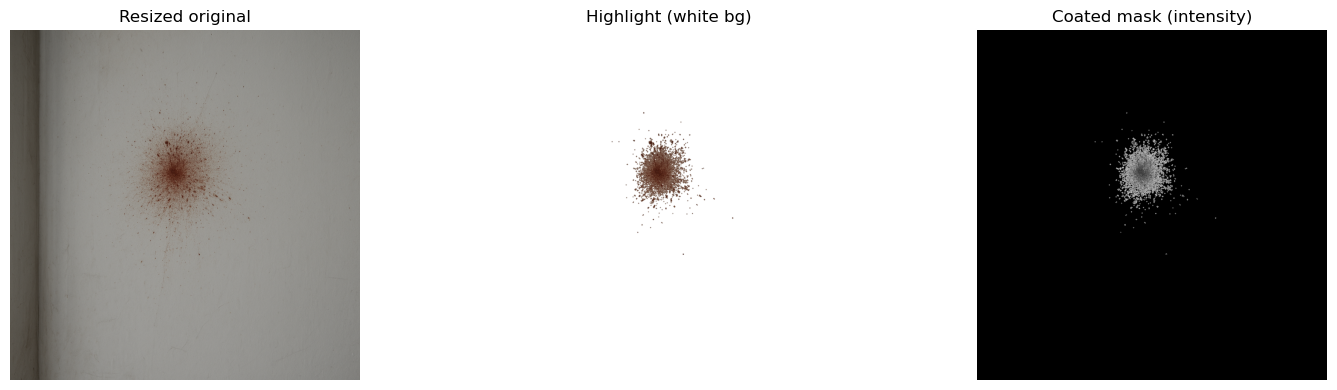

In [8]:

TEST_IMAGE_FEAT = r"C:\BPA\G2.png"   


img_test = load_image_bgr(TEST_IMAGE_FEAT)
if img_test is None:
    raise ValueError(f"Could not read test image: {TEST_IMAGE_FEAT}")

img_resized_test, _ = resize_fixed_scale(img_test, FIXED_SCALE)
H2, W2 = img_resized_test.shape[:2]


# Highlight + Coated mask (the only mask we use now)
highlight_test, coat_mask_test = make_highlight_and_coated(img_resized_test)


# Extract coated-only expert features

feats_test = extract_expert_features_coated(coat_mask_test, img_shape=(H2, W2))

# Colour features (RGB/HSV averages)
add_color_features_from_coated(feats_test, coat_mask_test, img_resized_test)

# Display feature row
df_test_feats = pd.DataFrame([feats_test])
print(" Extracted coated-only features for test image:")
print(f"  Path: {TEST_IMAGE_FEAT}")
display(df_test_feats)

# Visualization 
img_rgb  = cv2.cvtColor(img_resized_test,  cv2.COLOR_BGR2RGB)
hl_rgb   = cv2.cvtColor(highlight_test,    cv2.COLOR_BGR2RGB)
coat_show = coat_mask_test

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title("Resized original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(hl_rgb)
plt.title("Highlight (white bg)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(coat_show, cmap="gray")
plt.title("Coated mask (intensity)")
plt.axis("off")

plt.tight_layout()
plt.show()


GENERATING DATASET FOR MODEL TRAINING 

In [ ]:
def build_expert_dataset(data_root: str, class_map: Dict[str, str]) -> pd.DataFrame:
    rows: List[Dict[str, float]] = []   
    skipped: List[str] = []

    root_path = Path(data_root)
    if not root_path.exists():
        raise ValueError(f"DATA_ROOT does not exist: {data_root}")

    # Ensuring output dir exists and old CSV does not cause confusion
    out_dir = Path(os.path.dirname(FEATURE_CSV))
    out_dir.mkdir(parents=True, exist_ok=True)
    if os.path.exists(FEATURE_CSV):
        print(f"[INFO] Removing existing feature file: {FEATURE_CSV}")
        os.remove(FEATURE_CSV)

    for folder_name, label in class_map.items():
        folder_path = root_path / folder_name
        if not folder_path.exists():
            print(f"[WARN] Folder missing: {folder_path}")
            continue

        img_files = [
            f for f in os.listdir(folder_path)
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp"))
        ]
        img_files.sort()
        total_imgs = len(img_files)

        print(f"\n[INFO] Folder '{folder_name}' ({label}) → {total_imgs} images")

        for idx, fname in enumerate(img_files, start=1):
            print(f"\n Processing {fname}  ({idx}/{total_imgs}) ")

            img_path = str(folder_path / fname)

            # HARD RESET PER IMAGE (only temporaries) 
            img_resized = None
            highlight = None
            coat = None

            img = load_image_bgr(img_path)
            if img is None:
                print(f" Could not read even with fallback: {fname}")
                skipped.append(img_path)
                continue

            orig_h, orig_w = img.shape[:2]

            # RESIZE 
            img_resized, final_scale = resize_fixed_scale(img, FIXED_SCALE)
            new_h, new_w = img_resized.shape[:2]
            print(f" Resized size : {new_w} x {new_h}")
            print(f" Final scale used: {final_scale:.4f}")

            # This uses your _segment_blood_binary internally
            highlight, coat = make_highlight_and_coated(img_resized)

            # FEATURE EXTRACTION FROM COATED MASK 
            feats: Dict[str, float] = extract_expert_features_coated(
                coat, img_shape=(new_h, new_w)
            )
            add_color_features_from_coated(feats, coat, img_resized)

            feats["path"] = img_path
            feats["label"] = label

            # Append THIS image's features
            rows.append(feats)
            print(" Features extracted and stored")

        print(f" Finished folder: {folder_name}")

    if not rows:
        raise RuntimeError("No images processed. Check DATA_ROOT and CLASS_MAP.")

    # Build dataframe and SAVE 
    df = pd.DataFrame(rows)
    df.to_csv(FEATURE_CSV, index=False)
    print(f"\n Dataset built successfully and saved to: {FEATURE_CSV}")
    print(f" Total rows: {len(df)}")

    # Save skipped images list if any(Just for fallback pupose but no image will be skipped gaurenteed that part)
    if skipped:
        skipped_log = os.path.join(OUTPUT_DIR, "skipped_images.txt")
        with open(skipped_log, "w", encoding="utf-8") as f:
            for p in skipped:
                f.write(p + "\n")
        print(f" Skipped {len(skipped)} images. List saved to: {skipped_log}")
    else:
        print(" No images were skipped.")

    return df


# Build dataset (fresh each time, CSV overwritten) 
df_features = build_expert_dataset(DATA_ROOT, CLASS_MAP)



[INFO] Folder 'Gunshot' (gunshot) → 436 images

 Processing GS - 100.jpg  (1/436) 
 Resized size : 8000 x 6266
 Final scale used: 0.8000
 Features extracted and stored

 Processing GS - 101.jpg  (2/436) 
 Resized size : 8000 x 6266
 Final scale used: 0.8000
 Features extracted and stored

 Processing GS - 102.jpg  (3/436) 
 Resized size : 8000 x 6266
 Final scale used: 0.8000
 Features extracted and stored

 Processing GS - 103.jpg  (4/436) 
 Resized size : 8000 x 6266
 Final scale used: 0.8000
 Features extracted and stored

 Processing GS - 104.jpg  (5/436) 
 Resized size : 8000 x 6260
 Final scale used: 0.8000
 Features extracted and stored

 Processing GS - 105.jpg  (6/436) 
 Resized size : 8000 x 6260
 Final scale used: 0.8000
 Features extracted and stored

 Processing GS - 106.jpg  (7/436) 
 Resized size : 8000 x 6260
 Final scale used: 0.8000
 Features extracted and stored

 Processing GS - 107.jpg  (8/436) 
 Resized size : 8000 x 6260
 Final scale used: 0.8000
 Features extra

TRAINING THE MODELS AND SAVING THEM

In [ ]:
df_features = pd.read_csv(FEATURE_CSV)

feature_cols = [c for c in df_features.columns if c not in ("label", "path")]
X = df_features[feature_cols].values.astype(float)
y_str = df_features["label"].values

# Encode labels 
class_names = sorted(np.unique(y_str))          
label_to_int = {name: i for i, name in enumerate(class_names)}
int_to_label = {i: name for name, i in label_to_int.items()}

y = np.array([label_to_int[s] for s in y_str], dtype=int)

# --- Train / Test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_SEED
)

print("Train class distribution:", Counter(y_train))
print("Test  class distribution:", Counter(y_test))

# Train CatBoost (GPU) 

cat_model = CatBoostClassifier(
    iterations=2000,
    depth=8,
    learning_rate=0.02,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=RANDOM_SEED,
    task_type="GPU",             
    devices="0",
    auto_class_weights="Balanced",   
    verbose=False,
)

cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False,
)

# Quick argmax evaluation 
y_pred_argmax = cat_model.predict(X_test).astype(int)
print("\n[CatBoost argmax] Classification report:")
print(classification_report(y_test, y_pred_argmax,
                            target_names=class_names))

print("[CatBoost argmax] Confusion matrix:")
print(confusion_matrix(y_test, y_pred_argmax))

# Calibration setup 

# Find numeric label for 'gunshot'
gun_label = label_to_int["gunshot"]

# Get column index in predict_proba output for gunshot
classes_num = list(cat_model.classes_)          # numeric labels in order of proba columns
gun_col_idx = classes_num.index(gun_label)

# Raw gunshot scores
scores_train = cat_model.predict_proba(X_train)[:, gun_col_idx]
scores_test  = cat_model.predict_proba(X_test)[:, gun_col_idx]

# Binary targets: 1 = gunshot, 0 = impact
y_train_bin = (y_train == gun_label).astype(int)
y_test_bin  = (y_test  == gun_label).astype(int)

# Helper: Beta calibration class (for contingency) 
class BetaCalibrator:
    """
    Simple Beta calibration (binary).

    Fits: sigmoid(a*log(p) + b*log(1-p) + c)
    using LogisticRegression on transformed features.
    """
    def __init__(self, eps: float = 1e-6):
        self.eps = eps
        self._lr = LogisticRegression()

    def _transform(self, p: np.ndarray) -> np.ndarray:
        p = np.asarray(p).ravel()
        p = np.clip(p, self.eps, 1 - self.eps)
        return np.column_stack([np.log(p), np.log(1.0 - p)])

    def fit(self, p_raw: np.ndarray, y: np.ndarray):
        X_tr = self._transform(p_raw)
        self._lr.fit(X_tr, y.astype(int))
        return self

    def predict_proba(self, p_raw: np.ndarray) -> np.ndarray:
        X_te = self._transform(p_raw)
        # return probability of class=1 (gunshot)
        return self._lr.predict_proba(X_te)[:, 1]

# MAIN calibration: IsotonicRegression 
main_calibrator = IsotonicRegression(out_of_bounds="clip")
main_calibrator.fit(scores_train, y_train_bin)

probs_test_main = main_calibrator.predict(scores_test)
auc_raw  = roc_auc_score(y_test_bin, scores_test)
auc_main = roc_auc_score(y_test_bin, probs_test_main)

print(f"\n[Calibration] AUC raw:  {auc_raw:.4f}")
print(f"[Calibration] AUC main (Isotonic): {auc_main:.4f}")

# CONTINGENCY calibration: BetaCalibrator 

# Focus Beta calibration on "hard" mid-range cases where calibration matters most
mask_hard = (scores_train > 0.15) & (scores_train < 0.85)
if mask_hard.sum() < 20:
    # Fallback: use all if too few mid-range points
    mask_hard = np.ones_like(scores_train, dtype=bool)

beta_calibrator = BetaCalibrator(eps=1e-6)
beta_calibrator.fit(scores_train[mask_hard], y_train_bin[mask_hard])

probs_test_beta = beta_calibrator.predict_proba(scores_test)
auc_beta = roc_auc_score(y_test_bin, probs_test_beta)

print(f"[Calibration] AUC contingency (Beta): {auc_beta:.4f}")

# Save bundle with CatBoost + both calibrators 

bundle = {
    "cat_model": cat_model,
    "main_calibrator": main_calibrator,      # Isotonic for main path
    "beta_calibrator": beta_calibrator,      # Beta for contingency
    "feature_cols": feature_cols,
    "class_names": class_names,
    "label_to_int": label_to_int,
    "int_to_label": int_to_label,
    "gun_label": gun_label,
}


joblib.dump(bundle, MODEL_BUNDLE_PATH)
print(f"\nModel bundle (CatBoost + calibrations) saved to:\n  {MODEL_BUNDLE_PATH}")


Train class distribution: Counter({np.int64(1): 375, np.int64(0): 349})
Test  class distribution: Counter({np.int64(1): 94, np.int64(0): 87})


Default metric period is 5 because AUC is/are not implemented for GPU



[CatBoost argmax] Classification report:
              precision    recall  f1-score   support

     gunshot       0.94      0.95      0.95        87
      impact       0.96      0.95      0.95        94

    accuracy                           0.95       181
   macro avg       0.95      0.95      0.95       181
weighted avg       0.95      0.95      0.95       181

[CatBoost argmax] Confusion matrix:
[[83  4]
 [ 5 89]]

[Calibration] AUC raw:  0.9936
[Calibration] AUC main (Isotonic): 0.9733
[Calibration] AUC contingency (Beta): 0.9936

Model bundle (CatBoost + calibrations) saved to:
  C:\BPA\final\model\model_bundle_expert.pkl


IMAGE PREDICTION

In [6]:
# Cell 9 — Single-image prediction with contingency (CatBoost + calibrated probs)

# Make sure BetaCalibrator class is defined BEFORE loading the bundle
class BetaCalibrator:
    def __init__(self, eps: float = 1e-6):
        self.eps = eps
        self._lr = LogisticRegression()

    def _transform(self, p: np.ndarray) -> np.ndarray:
        p = np.asarray(p).ravel()
        p = np.clip(p, self.eps, 1 - self.eps)
        return np.column_stack([np.log(p), np.log(1.0 - p)])

    def fit(self, p_raw: np.ndarray, y: np.ndarray):
        X_tr = self._transform(p_raw)
        self._lr.fit(X_tr, y.astype(int))
        return self

    def predict_proba(self, p_raw: np.ndarray) -> np.ndarray:
        X_te = self._transform(p_raw)
        return self._lr.predict_proba(X_te)[:, 1]

bundle = joblib.load(MODEL_BUNDLE_PATH)

cat_model       = bundle["cat_model"]
main_calibrator = bundle["main_calibrator"]    # Isotonic
beta_calibrator = bundle["beta_calibrator"]    # Beta (for contingency)
feature_cols    = bundle["feature_cols"]
class_names     = bundle["class_names"]
label_to_int    = bundle["label_to_int"]
int_to_label    = bundle["int_to_label"]
gun_label       = bundle["gun_label"]

# fixed order for probs: index 0 = impact, index 1 = gunshot
ORDERED_CLASSES = ["impact", "gunshot"]

# locate gunshot column in CatBoost outputs
classes_num = list(cat_model.classes_)
gun_col_idx = classes_num.index(gun_label)

# contingency triggers
CONF_THRESHOLD   = 0.80      # stricter: if max prob < this → run contingency
MIN_BLOOD_COV    = 5e-4      # very weak mask
MIN_TOTAL_STAINS = 3         # almost empty segmentation

def _clip_prob(p: float, eps: float = 1e-3) -> float:
    """
    Avoid exact 0.0 or 1.0 by clipping into [eps, 1 - eps].
    This keeps decisions the same but makes confidences look less extreme.
    """
    return float(np.clip(p, eps, 1.0 - eps))

def _calibrated_proba_main(X_row_2d: np.ndarray) -> np.ndarray:
    """
    MAIN path calibration using IsotonicRegression.
    Returns [P(impact), P(gunshot)].
    """
    raw_scores = cat_model.predict_proba(X_row_2d)[:, gun_col_idx]  
    gun_cal = float(main_calibrator.predict(raw_scores)[0])
    gun_cal = _clip_prob(gun_cal)         
    imp_cal = 1.0 - gun_cal
    return np.array([imp_cal, gun_cal], dtype=float)


def _calibrated_proba_cont(X_row_2d: np.ndarray) -> np.ndarray:
    """
    CONTINGENCY path calibration using BetaCalibrator.
    Returns [P(impact), P(gunshot)].
    """
    raw_scores = cat_model.predict_proba(X_row_2d)[:, gun_col_idx] 
    gun_cal = float(beta_calibrator.predict_proba(raw_scores)[0])
    gun_cal = _clip_prob(gun_cal)         
    imp_cal = 1.0 - gun_cal
    return np.array([imp_cal, gun_cal], dtype=float)


def _features_to_row(feats: Dict[str, float]) -> np.ndarray:
    #Map feature dict into a 1xN row aligned to feature_cols.
    row = {c: 0.0 for c in feature_cols}
    for k, v in feats.items():
        if k in row:
            row[k] = float(v)
    return pd.DataFrame([row], columns=feature_cols).values.astype(float)


def predict_image_expert(img_path: str) -> Dict[str, object]:
    img = load_image_bgr(img_path)
    if img is None:
        raise ValueError(f"Could not read file: {img_path}")

    orig_h, orig_w = img.shape[:2]
    img_resized, final_scale = resize_fixed_scale(img, FIXED_SCALE)
    H2, W2 = img_resized.shape[:2]

    fname = os.path.basename(img_path)
    print(f"[SIZE] {fname}")
    print(f"       original: {orig_w} x {orig_h}")
    print(f"       final:    {W2} x {H2}")
    print(f"       scale:    {final_scale:.4f}\n")

    # MAIN segmentation → coated mask 
    hl_main, coat_main = make_highlight_and_coated(img_resized)

    feats_main = extract_expert_features_coated(coat_main, img_shape=(H2, W2))
    add_color_features_from_coated(feats_main, coat_main, img_resized)

    X_row_main = _features_to_row(feats_main)
    probs_main_vec = _calibrated_proba_main(X_row_main)   

    max_main = float(probs_main_vec.max())
    cls_main = ORDERED_CLASSES[int(np.argmax(probs_main_vec))]

    print(f"[MAIN] {fname} -> {cls_main}  (conf={max_main:.3f})")
    print("       Probs(main):", {c: round(float(p), 3) for c, p in zip(ORDERED_CLASSES, probs_main_vec)})

    blood_cov    = feats_main.get("blood_coverage", 0.0)
    total_stains = feats_main.get("total_stains", 0.0)

    low_conf   = max_main < CONF_THRESHOLD
    weak_mask  = blood_cov < MIN_BLOOD_COV
    few_stains = total_stains < MIN_TOTAL_STAINS

    need_contingency = low_conf or weak_mask or few_stains

    final_label = cls_main
    final_conf  = max_main
    final_probs = probs_main_vec.copy()
    final_feats = feats_main
    final_mask  = coat_main

    used_cont   = False
    mask_main   = coat_main       
    mask_cont   = None            

    # CONTINGENCY path (small-stain only) 
    if need_contingency:
        print(" -> Triggering contingency (",
              f"low_conf={low_conf}, weak_mask={weak_mask}, few_stains={few_stains}",
              ")")

        # max_small_area can be tuned 200 is a reasonable starting point.
        hl_cont, coat_cont = make_highlight_and_coated_contingency(img_resized,
                                                                   max_small_area=200)

        feats_cont = extract_expert_features_coated(coat_cont, img_shape=(H2, W2))
        add_color_features_from_coated(feats_cont, coat_cont, img_resized) 
        mask_cont = coat_cont   # <--- NEW: remember contingency mask

        X_row_cont = _features_to_row(feats_cont)
        probs_cont_vec = _calibrated_proba_cont(X_row_cont)

        max_cont = float(probs_cont_vec.max())
        cls_cont = ORDERED_CLASSES[int(np.argmax(probs_cont_vec))]
       


        print(f"[CONT] {fname} -> {cls_cont}  (conf={max_cont:.3f})")
        print("       Probs(cont):", {c: round(float(p), 3) for c, p in zip(ORDERED_CLASSES, probs_cont_vec)})


        # SAFER OVERRIDE LOGIC 
        STRONG_MAIN_CONF   = 0.75   # above this, main is trusted
        RESCUE_MAIN_MAX    = 0.50   # below this, main is "weak"
        RESCUE_CONT_MIN    = 0.75   # contingency must be this strong to rescue
        RESCUE_DELTA       = 0.15   # contingency must beat main by at least this much

     
        final_label = cls_main
        final_conf  = max_main
        final_probs = probs_main_vec.copy()
        final_feats = feats_main
        final_mask  = coat_main
        used_cont   = False

        if max_main >= STRONG_MAIN_CONF:
            print(" Main is strong so ignoring contingency override")
        else:
            if cls_cont == cls_main:
                # Same label: can safely boost confidence if stronger
                if max_cont > max_main:
                    print(" Contingency is more confident so boosting with contingency")
                    used_cont   = True
                    final_label = cls_cont
                    final_conf  = max_cont
                    final_probs = probs_cont_vec.copy()
                    final_feats = feats_cont
                    final_mask  = coat_cont
                else:
                    print(" Contingency agrees but is weaker than what we had so keeping main.")
            else:
                # Different label: only allow rescue if main is very weak and contingency is very strong
                if (max_main < RESCUE_MAIN_MAX) and (max_cont >= RESCUE_CONT_MIN) and ((max_cont - max_main) >= RESCUE_DELTA):
                    print(" Contingency result is more so going with that ignoring main prediction for this case")
                    used_cont   = True
                    final_label = cls_cont
                    final_conf  = max_cont
                    final_probs = probs_cont_vec.copy()
                    final_feats = feats_cont
                    final_mask  = coat_cont
                else:
                    print(" Labels differ but main not weak enough / contingency not strong enough keeping main.")
    else:
        print(" Main path confident so no contingency needed.")

    print(f"\n[FINAL] {fname} -> {final_label} (conf={final_conf:.3f})")

    return {
        "path": img_path,
        "pred_label": final_label,
        "confidence": final_conf,
        "probs": {c: float(p) for c, p in zip(ORDERED_CLASSES, final_probs)},
        "features": final_feats,
        "mask": final_mask,              
        "mask_main": mask_main,          
        "mask_cont": mask_cont,          
        "used_contingency": used_cont,
        "model_used": "catboost + contingency",
    }



IMAGE TESTING - DATASET

[SIZE] GS - 112.jpg
       original: 10000 x 7804
       final:    8000 x 6243
       scale:    0.8000

[MAIN] GS - 112.jpg -> gunshot  (conf=0.969)
       Probs(main): {'impact': 0.031, 'gunshot': 0.969}
 Main path confident so no contingency needed.

[FINAL] GS - 112.jpg -> gunshot (conf=0.969)

Prediction summary:
  Path       : C:\BPA\data\Gunshot\GS - 112.jpg
  Label      : gunshot
  Confidence : 0.969
    impact    : 0.031
    gunshot   : 0.969
  Used contingency: False


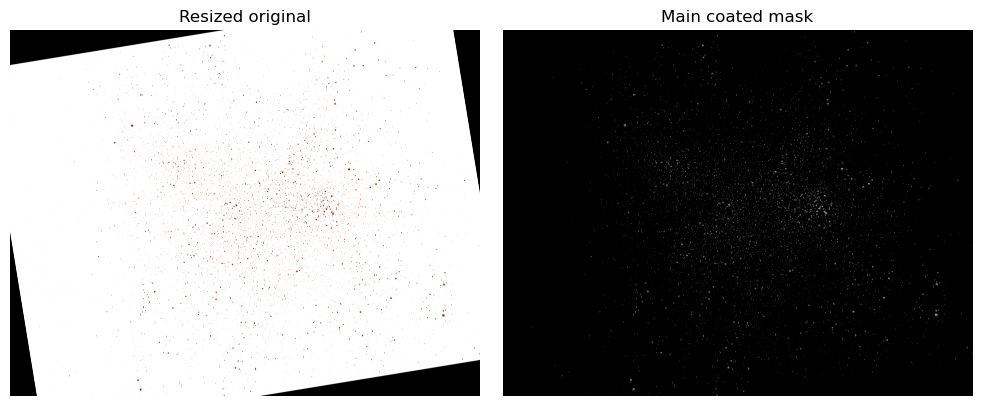

In [7]:
# quick smoke test (you can change the path)
test_path = r"C:\BPA\data\Gunshot\GS - 112.jpg"
result = predict_image_expert(test_path)

print("\nPrediction summary:")
print(f"  Path       : {result['path']}")
print(f"  Label      : {result['pred_label']}")
print(f"  Confidence : {result['confidence']:.3f}")
for cls, p in result["probs"].items():
    print(f"    {cls:10s}: {p:.3f}")
print(f"  Used contingency: {result['used_contingency']}")

# visualize original vs masks
img_show = load_image_bgr(test_path)
img_resized_show, _ = resize_fixed_scale(img_show, FIXED_SCALE)
img_rgb_show = cv2.cvtColor(img_resized_show, cv2.COLOR_BGR2RGB)

mask_main = result["mask_main"]
mask_cont = result["mask_cont"]
used_cont = result["used_contingency"]

if used_cont and mask_cont is not None:
    # show original + main + contingency
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb_show)
    plt.title("Resized original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_main, cmap="gray")
    plt.title("Main coated mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(mask_cont, cmap="gray")
    plt.title("Contingency coated mask (small stains)")
    plt.axis("off")
else:
    # show original + main only (no contingency used)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb_show)
    plt.title("Resized original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_main, cmap="gray")
    plt.title("Main coated mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


Image from Dataset for impact 

 Image too large after base scale so extra downscale applied.
 final scale = 0.3723, final size = 6374 x 10000
[SIZE] HP_25.jpg
       original: 17120 x 26860
       final:    6374 x 10000
       scale:    0.3723

[MAIN] HP_25.jpg -> impact  (conf=0.999)
       Probs(main): {'impact': 0.999, 'gunshot': 0.001}
 Main path confident so no contingency needed.

[FINAL] HP_25.jpg -> impact (conf=0.999)

Prediction summary:
  Path       : C:\BPA\data\Impact\HP_25.jpg
  Label      : impact
  Confidence : 0.999
    impact    : 0.999
    gunshot   : 0.001
  Used contingency: False
 Image too large after base scale so extra downscale applied.
 final scale = 0.3723, final size = 6374 x 10000


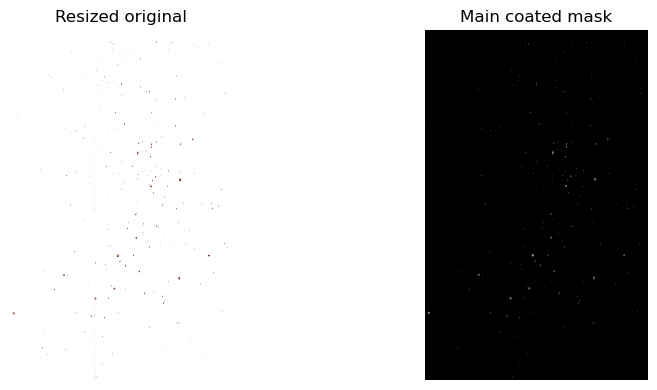

In [40]:
# quick smoke test (you can change the path)
test_path = r"C:\BPA\data\Impact\HP_25.jpg"
result = predict_image_expert(test_path)

print("\nPrediction summary:")
print(f"  Path       : {result['path']}")
print(f"  Label      : {result['pred_label']}")
print(f"  Confidence : {result['confidence']:.3f}")
for cls, p in result["probs"].items():
    print(f"    {cls:10s}: {p:.3f}")
print(f"  Used contingency: {result['used_contingency']}")

# visualize original vs masks
img_show = load_image_bgr(test_path)
img_resized_show, _ = resize_fixed_scale(img_show, FIXED_SCALE)
img_rgb_show = cv2.cvtColor(img_resized_show, cv2.COLOR_BGR2RGB)

mask_main = result["mask_main"]
mask_cont = result["mask_cont"]
used_cont = result["used_contingency"]

if used_cont and mask_cont is not None:
    # show original + main + contingency
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb_show)
    plt.title("Resized original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_main, cmap="gray")
    plt.title("Main coated mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(mask_cont, cmap="gray")
    plt.title("Contingency coated mask (small stains)")
    plt.axis("off")
else:
    # show original + main only (no contingency used)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb_show)
    plt.title("Resized original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_main, cmap="gray")
    plt.title("Main coated mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


EXTERNAL IMAGES 


AI Created Image for Gunshot spatter 

[SIZE] G2.png
       original: 1024 x 1024
       final:    819 x 819
       scale:    0.8000

[MAIN] G2.png -> gunshot  (conf=0.647)
       Probs(main): {'impact': 0.353, 'gunshot': 0.647}
 -> Triggering contingency ( low_conf=True, weak_mask=False, few_stains=False )
[CONT] G2.png -> gunshot  (conf=0.905)
       Probs(cont): {'impact': 0.095, 'gunshot': 0.905}
 Contingency is more confident so boosting with contingency

[FINAL] G2.png -> gunshot (conf=0.905)

Prediction summary:
  Path       : C:\BPA\G2.png
  Label      : gunshot
  Confidence : 0.905
    impact    : 0.095
    gunshot   : 0.905
  Used contingency: True


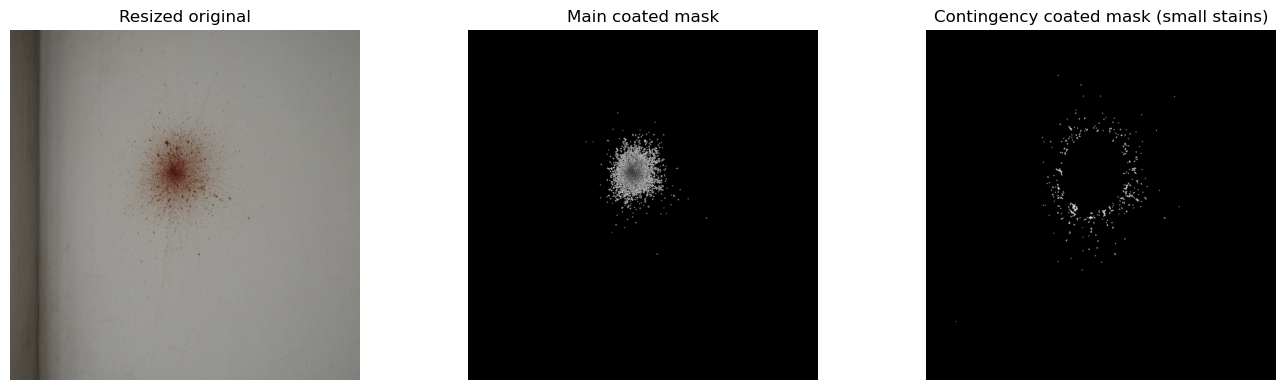

In [37]:
# quick smoke test (you can change the path)
test_path = r"C:\BPA\G2.png"
result = predict_image_expert(test_path)

print("\nPrediction summary:")
print(f"  Path       : {result['path']}")
print(f"  Label      : {result['pred_label']}")
print(f"  Confidence : {result['confidence']:.3f}")
for cls, p in result["probs"].items():
    print(f"    {cls:10s}: {p:.3f}")
print(f"  Used contingency: {result['used_contingency']}")

# visualize original vs masks
img_show = load_image_bgr(test_path)
img_resized_show, _ = resize_fixed_scale(img_show, FIXED_SCALE)
img_rgb_show = cv2.cvtColor(img_resized_show, cv2.COLOR_BGR2RGB)

mask_main = result["mask_main"]
mask_cont = result["mask_cont"]
used_cont = result["used_contingency"]

if used_cont and mask_cont is not None:
    # show original + main + contingency
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb_show)
    plt.title("Resized original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_main, cmap="gray")
    plt.title("Main coated mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(mask_cont, cmap="gray")
    plt.title("Contingency coated mask (small stains)")
    plt.axis("off")
else:
    # show original + main only (no contingency used)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb_show)
    plt.title("Resized original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_main, cmap="gray")
    plt.title("Main coated mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


External impact image taken random from net 

[SIZE] imp.jpg
       original: 297 x 843
       final:    238 x 674
       scale:    0.8000

[MAIN] imp.jpg -> impact  (conf=0.999)
       Probs(main): {'impact': 0.999, 'gunshot': 0.001}
 Main path confident so no contingency needed.

[FINAL] imp.jpg -> impact (conf=0.999)

Prediction summary:
  Path       : C:\BPA\imp.jpg
  Label      : impact
  Confidence : 0.999
    impact    : 0.999
    gunshot   : 0.001
  Used contingency: False


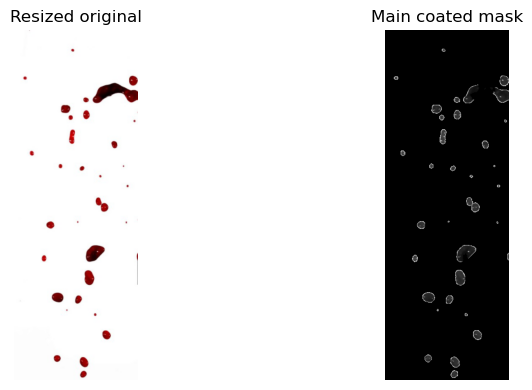

In [41]:
test_path = r"C:\BPA\imp.jpg"
result = predict_image_expert(test_path)

print("\nPrediction summary:")
print(f"  Path       : {result['path']}")
print(f"  Label      : {result['pred_label']}")
print(f"  Confidence : {result['confidence']:.3f}")
for cls, p in result["probs"].items():
    print(f"    {cls:10s}: {p:.3f}")
print(f"  Used contingency: {result['used_contingency']}")

# visualize original vs masks
img_show = load_image_bgr(test_path)
img_resized_show, _ = resize_fixed_scale(img_show, FIXED_SCALE)
img_rgb_show = cv2.cvtColor(img_resized_show, cv2.COLOR_BGR2RGB)

mask_main = result["mask_main"]
mask_cont = result["mask_cont"]
used_cont = result["used_contingency"]

if used_cont and mask_cont is not None:
    # show original + main + contingency
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb_show)
    plt.title("Resized original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_main, cmap="gray")
    plt.title("Main coated mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(mask_cont, cmap="gray")
    plt.title("Contingency coated mask (small stains)")
    plt.axis("off")
else:
    # show original + main only (no contingency used)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb_show)
    plt.title("Resized original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_main, cmap="gray")
    plt.title("Main coated mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


EVALUATION 

=== Classification report (argmax decision) ===
              precision    recall  f1-score   support

     gunshot       0.94      0.95      0.95        87
      impact       0.96      0.95      0.95        94

    accuracy                           0.95       181
   macro avg       0.95      0.95      0.95       181
weighted avg       0.95      0.95      0.95       181

Confusion matrix (argmax):
[[83  4]
 [ 5 89]]

[ROC AUC] Raw CatBoost scores:      0.9936
[ROC AUC] Main calib (Isotonic):    0.9733
[ROC AUC] Contingency calib (Beta): 0.9936


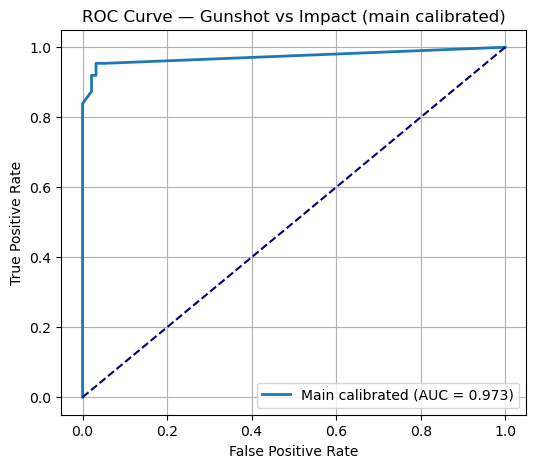

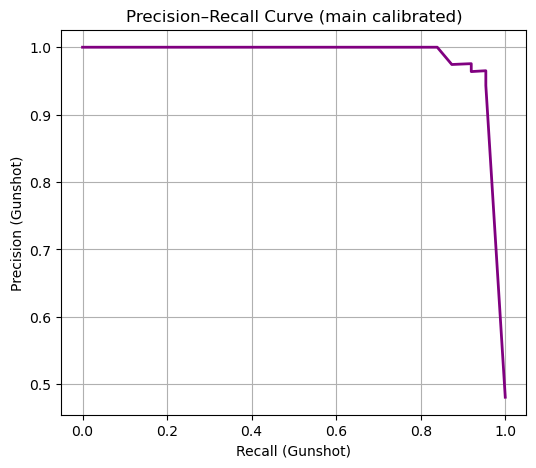


[MAIN] Best F1 Threshold (P(gunshot)): 0.425  |  F1 = 0.960


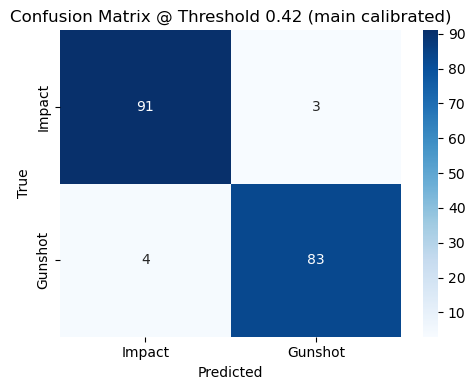


[CONTINGENCY] Best F1 Threshold (P(gunshot)): 0.060  |  F1 = 0.960


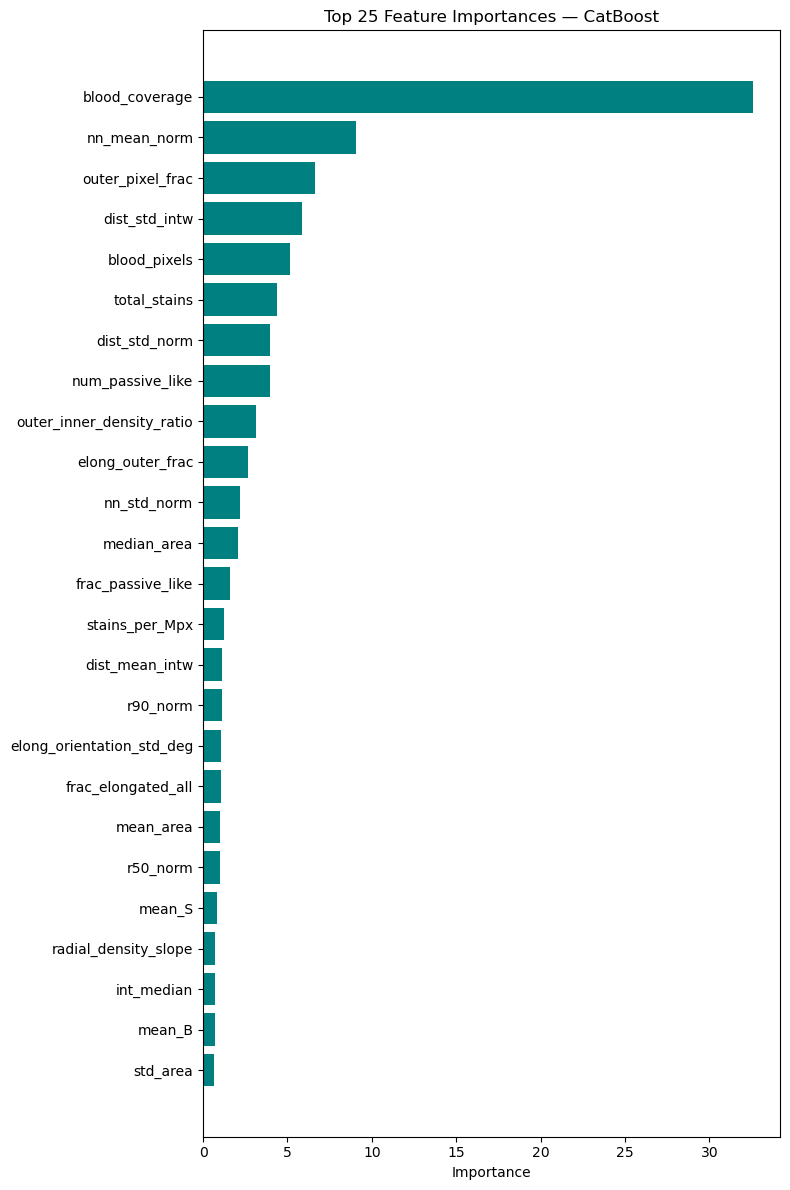

In [ ]:
# ROC, PR, Argmax Report, Best Threshold CM, Feature Importances
#  BetaCalibrator definition must exist before loading bundle 
class BetaCalibrator:
    
    # Same class used in training: Beta calibration on raw probs.
    def __init__(self, eps: float = 1e-6):
        self.eps = eps
        from sklearn.linear_model import LogisticRegression
        self._lr = LogisticRegression()

    def _transform(self, p: np.ndarray) -> np.ndarray:
        p = np.asarray(p).ravel()
        p = np.clip(p, self.eps, 1 - self.eps)
        return np.column_stack([np.log(p), np.log(1.0 - p)])

    def fit(self, p_raw: np.ndarray, y: np.ndarray):
        X_tr = self._transform(p_raw)
        self._lr.fit(X_tr, y.astype(int))
        return self

    def predict_proba(self, p_raw: np.ndarray) -> np.ndarray:
        X_te = self._transform(p_raw)
        return self._lr.predict_proba(X_te)[:, 1]


#  Load model bundle + feature dataset 

bundle = joblib.load(MODEL_BUNDLE_PATH)

cat_model       = bundle["cat_model"]       # CatBoost model
main_calibrator = bundle["main_calibrator"] # Isotonic calibration (main path)
beta_calibrator = bundle["beta_calibrator"] # Beta calibration (contingency)

feature_cols = bundle["feature_cols"]
label_to_int = bundle["label_to_int"]
int_to_label = bundle["int_to_label"]
gun_label    = bundle["gun_label"]

df = pd.read_csv(FEATURE_CSV)
X = df[feature_cols].values.astype(float)
y_str = df["label"].values
y = np.array([label_to_int[s] for s in y_str], dtype=int)

# Same split as training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_SEED
)

# Column index for gunshot in cat_model.predict_proba output
classes_num = list(cat_model.classes_)        
gun_col_idx = classes_num.index(gun_label)

# Binary targets: 1 = gunshot, 0 = impact
y_test_bin = (y_test == gun_label).astype(int)

# Argmax classification report (no calibration, just max-prob class)

y_pred_argmax = cat_model.predict(X_test).astype(int)

print("=== Classification report (argmax decision) ===")
print(classification_report(
    y_test,
    y_pred_argmax,
    target_names=[int_to_label[0], int_to_label[1]]
))

print("Confusion matrix (argmax):")
print(confusion_matrix(y_test, y_pred_argmax))



# raw gunshot scores from CatBoost
raw_scores_test = cat_model.predict_proba(X_test)[:, gun_col_idx]

# main calibrated P(gunshot) (Isotonic)
probs_gun_main = main_calibrator.predict(raw_scores_test)

# contingency-style calibrated P(gunshot) (Beta)
probs_gun_beta = beta_calibrator.predict_proba(raw_scores_test)

# AUC comparison
auc_raw   = roc_auc_score(y_test_bin, raw_scores_test)
auc_main  = roc_auc_score(y_test_bin, probs_gun_main)
auc_beta  = roc_auc_score(y_test_bin, probs_gun_beta)

print(f"\n[ROC AUC] Raw CatBoost scores:      {auc_raw:.4f}")
print(f"[ROC AUC] Main calib (Isotonic):    {auc_main:.4f}")
print(f"[ROC AUC] Contingency calib (Beta): {auc_beta:.4f}")


#  ROC + PR for MAIN calibrated probabilities

fpr, tpr, _ = roc_curve(y_test_bin, probs_gun_main, pos_label=1)
roc_auc_main = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, lw=2, label=f"Main calibrated (AUC = {roc_auc_main:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="navy")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Gunshot vs Impact (main calibrated)")
plt.legend()
plt.grid(True)
plt.show()

# Precision–Recall Curve (main)
precision, recall, _ = precision_recall_curve(y_test_bin, probs_gun_main, pos_label=1)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, lw=2, color="purple")
plt.xlabel("Recall (Gunshot)")
plt.ylabel("Precision (Gunshot)")
plt.title("Precision–Recall Curve (main calibrated)")
plt.grid(True)
plt.show()


# Best-F1 threshold for MAIN calibrated probs + Confusion Matrix
thresholds = np.linspace(0.0, 1.0, 201)
f1_scores = []

for t in thresholds:
    y_pred_t = (probs_gun_main >= t).astype(int)
    f1_scores.append(f1_score(y_test_bin, y_pred_t))

f1_scores = np.array(f1_scores)
best_idx = int(np.argmax(f1_scores))
best_threshold_main = float(thresholds[best_idx])
best_f1_main = float(f1_scores[best_idx])

print(f"\n[MAIN] Best F1 Threshold (P(gunshot)): {best_threshold_main:.3f}  |  F1 = {best_f1_main:.3f}")

y_pred_best_main = (probs_gun_main >= best_threshold_main).astype(int)

cm_main = confusion_matrix(y_test_bin, y_pred_best_main)   # rows/cols: [impact(0), gunshot(1)]

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_main,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=["Impact", "Gunshot"],
    yticklabels=["Impact", "Gunshot"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix @ Threshold {best_threshold_main:.2f} (main calibrated)")
plt.tight_layout()
plt.show()

# Best-F1 threshold for BETA (contingency-style) calibration to inspect how the contingency calibrator behaves numerically.
f1_scores_beta = []
for t in thresholds:
    y_pred_t = (probs_gun_beta >= t).astype(int)
    f1_scores_beta.append(f1_score(y_test_bin, y_pred_t))

f1_scores_beta = np.array(f1_scores_beta)
best_idx_beta = int(np.argmax(f1_scores_beta))
best_threshold_beta = float(thresholds[best_idx_beta])
best_f1_beta = float(f1_scores_beta[best_idx_beta])

print(f"\n[CONTINGENCY] Best F1 Threshold (P(gunshot)): {best_threshold_beta:.3f}  |  F1 = {best_f1_beta:.3f}")



# CatBoost Feature Importances (top 25)
importances = cat_model.get_feature_importance()
sorted_idx = np.argsort(importances)[::-1]

top_k = min(25, len(feature_cols))
top_features = [feature_cols[i] for i in sorted_idx[:top_k]]
top_importances = importances[sorted_idx[:top_k]]

plt.figure(figsize=(8, 0.4 * top_k + 2))
plt.barh(top_features, top_importances, color="teal")
plt.gca().invert_yaxis()
plt.title("Top 25 Feature Importances — CatBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


SIS COMPUTATION 

In [ ]:
# Recreating the train/test split for SIS

import pandas as pd
from sklearn.model_selection import train_test_split

# Load feature dataset again (or reuse df_features)
df_features = pd.read_csv(FEATURE_CSV)

feature_cols = [c for c in df_features.columns if c not in ("label", "path")]

# Binary target for SIS
y_all = (df_features["label"].values == "gunshot").astype(int)

X_all_df = df_features[feature_cols].astype(float)

X_train_df, X_test_df, y_train_bin, y_test_bin = train_test_split(
    X_all_df,
    y_all,
    test_size=0.20,
    stratify=y_all,
    random_state=RANDOM_SEED,
)

print("Train size:", X_train_df.shape)
print("Test size :", X_test_df.shape)


Train size: (724, 48)
Test size : (181, 48)


In [ ]:
# Pipeline probability functions for SIS

import numpy as np

# fixed decision threshold 
BEST_THRESHOLD    = 0.50   

# same gates as your image pipeline
CONF_THRESHOLD    = 0.80
MIN_BLOOD_COV     = 5e-4
MIN_TOTAL_STAINS  = 3

STRONG_MAIN_CONF  = 0.75
RESCUE_MAIN_MAX   = 0.50
RESCUE_CONT_MIN   = 0.75
RESCUE_DELTA      = 0.15

# locate gunshot column
classes_num = list(cat_model.classes_)   
gun_col_idx = classes_num.index(gun_label)

def _clip_prob_vec(p: np.ndarray, eps: float = 1e-3) -> np.ndarray:
    return np.clip(p, eps, 1.0 - eps)


def pipeline_proba_main_only(X_df: pd.DataFrame) -> np.ndarray:
    """
    Given a DataFrame of features, return calibrated P(gunshot)
    using ONLY the main (Isotonic) path.
    """
    X_mat = X_df[feature_cols].values.astype(float)
    raw_scores = cat_model.predict_proba(X_mat)[:, gun_col_idx]
    probs_gun = main_calibrator.predict(raw_scores)
    probs_gun = _clip_prob_vec(probs_gun)
    return probs_gun   # shape (n_samples,)


def pipeline_proba_with_contingency(X_df: pd.DataFrame) -> np.ndarray:
    """
    Full pipeline approximation on FEATURES:
      - main (Isotonic) probability
      - apply gates (CONF_THRESHOLD, blood_coverage, total_stains)
      - optionally override with BetaCalibrator using same rescue logic.
    Returns P(gunshot) for each row.
    """
    X_mat = X_df[feature_cols].values.astype(float)
    raw_scores = cat_model.predict_proba(X_mat)[:, gun_col_idx]

    probs_main = main_calibrator.predict(raw_scores)      # P(gunshot)
    probs_main = _clip_prob_vec(probs_main)
    max_main   = np.maximum(probs_main, 1.0 - probs_main)

    # gating features
    blood_cov    = X_df["blood_coverage"].values
    total_stains = X_df["total_stains"].values

    low_conf   = max_main < CONF_THRESHOLD
    weak_mask  = blood_cov < MIN_BLOOD_COV
    few_stains = total_stains < MIN_TOTAL_STAINS

    need_cont  = low_conf | weak_mask | few_stains

    probs_final = probs_main.copy()

    if need_cont.any():
        raw_sub   = raw_scores[need_cont]
        probs_cont_sub = beta_calibrator.predict_proba(raw_sub)
        probs_cont_sub = _clip_prob_vec(probs_cont_sub)

        main_sub     = probs_main[need_cont]
        max_main_sub = np.maximum(main_sub, 1.0 - main_sub)
        max_cont_sub = np.maximum(probs_cont_sub, 1.0 - probs_cont_sub)

        cls_main_sub = (main_sub >= 0.5).astype(int)
        cls_cont_sub = (probs_cont_sub >= 0.5).astype(int)

        use_cont = np.zeros_like(main_sub, dtype=bool)

        # case 1: main strong → never override
        strong_main_mask = max_main_sub >= STRONG_MAIN_CONF
        weak_main_mask   = ~strong_main_mask

        # case 2: same label, contingency more confident → boost
        same_label = cls_main_sub == cls_cont_sub
        boost_mask = weak_main_mask & same_label & (max_cont_sub > max_main_sub)
        use_cont  |= boost_mask

        # case 3: different label, strong rescue
        diff_label   = ~same_label
        rescue_mask  = (
            weak_main_mask &
            diff_label &
            (max_main_sub < RESCUE_MAIN_MAX) &
            (max_cont_sub >= RESCUE_CONT_MIN) &
            ((max_cont_sub - max_main_sub) >= RESCUE_DELTA)
        )
        use_cont |= rescue_mask

        # apply overrides only for need_cont subset
        tmp = main_sub.copy()
        tmp[use_cont] = probs_cont_sub[use_cont]
        probs_final[need_cont] = tmp

    return probs_final   


In [ ]:
# SIS computation



def compute_sis_for_pipeline(proba_func,
                             X_test_df: pd.DataFrame,
                             y_test_bin: np.ndarray,
                             feature_cols: list,
                             name: str = "Pipeline"):
    """
    proba_func: X_test_df -> P(gunshot) as 1D array.
    Returns: baseline metrics and SIS DataFrame (per-feature drops).
    """
    # ---- Baseline ----
    base_probs = proba_func(X_test_df)                     # shape (n_samples,)
    base_pred  = (base_probs >= BEST_THRESHOLD).astype(int)

    acc_base = accuracy_score(y_test_bin, base_pred)
    f1_base  = f1_score(y_test_bin, base_pred)

    print(f"\n[{name}] Baseline metrics:")
    print(f"  Accuracy: {acc_base:.4f}")
    print(f"  F1-score: {f1_base:.4f}")

    # Neutral values for occlusion
    medians = X_test_df[feature_cols].median()

    sis_rows = []

    for feat in feature_cols:
        X_mod = X_test_df.copy()
        X_mod[feat] = medians[feat]

        probs_mod = proba_func(X_mod)
        pred_mod  = (probs_mod >= BEST_THRESHOLD).astype(int)

        acc_mod = accuracy_score(y_test_bin, pred_mod)
        f1_mod  = f1_score(y_test_bin, pred_mod)

        sis_rows.append({
            "feature": feat,
            "acc_baseline": acc_base,
            "f1_baseline": f1_base,
            "acc_occluded": acc_mod,
            "f1_occluded": f1_mod,
            "acc_drop": acc_base - acc_mod,
            "f1_drop": f1_base - f1_mod,
        })

    df_sis = pd.DataFrame(sis_rows).sort_values("f1_drop", ascending=False)
    return acc_base, f1_base, df_sis


# ---- Run SIS for both pipelines ----
acc_main, f1_main, df_sis_main = compute_sis_for_pipeline(
    pipeline_proba_main_only,
    X_test_df,
    y_test_bin,
    feature_cols,
    name="Pipeline A — Main only (Isotonic)"
)

acc_cont, f1_cont, df_sis_cont = compute_sis_for_pipeline(
    pipeline_proba_with_contingency,
    X_test_df,
    y_test_bin,
    feature_cols,
    name="Pipeline B — Main + Contingency"
)

print("\nTop 20 SIS features for Pipeline A (main only):")
display(df_sis_main.head(20))

print("\nTop 20 SIS features for Pipeline B (main + contingency):")
display(df_sis_cont.head(20))



[Pipeline A — Main only (Isotonic)] Baseline metrics:
  Accuracy: 0.9890
  F1-score: 0.9885

[Pipeline B — Main + Contingency] Baseline metrics:
  Accuracy: 0.9890
  F1-score: 0.9885

Top 20 SIS features for Pipeline A (main only):


,feature,acc_baseline,f1_baseline,acc_occluded,f1_occluded,acc_drop,f1_drop
1,blood_coverage,0.98895,0.988506,0.773481,0.691729,0.215470,0.296776
40,nn_mean_norm,0.98895,0.988506,0.977901,0.977273,0.011050,0.011233
33,outer_inner_density_ratio,0.98895,0.988506,0.983425,0.982659,0.005525,0.005847
13,total_stains,0.98895,0.988506,0.983425,0.982659,0.005525,0.005847
39,elong_outer_frac,0.98895,0.988506,0.983425,0.982659,0.005525,0.005847
32,outer_pixel_frac,0.98895,0.988506,0.983425,0.982659,0.005525,0.005847
2,int_mean,0.98895,0.988506,0.988950,0.988506,0.000000,0.000000
0,blood_pixels,0.98895,0.988506,0.988950,0.988506,0.000000,0.000000
7,int_p10,0.98895,0.988506,0.988950,0.988506,0.000000,0.000000
8,int_p90,0.98895,0.988506,0.988950,0.988506,0.000000,0.000000



Top 20 SIS features for Pipeline B (main + contingency):


,feature,acc_baseline,f1_baseline,acc_occluded,f1_occluded,acc_drop,f1_drop
1,blood_coverage,0.98895,0.988506,0.773481,0.691729,0.215470,0.296776
40,nn_mean_norm,0.98895,0.988506,0.977901,0.977273,0.011050,0.011233
33,outer_inner_density_ratio,0.98895,0.988506,0.983425,0.982659,0.005525,0.005847
13,total_stains,0.98895,0.988506,0.983425,0.982659,0.005525,0.005847
39,elong_outer_frac,0.98895,0.988506,0.983425,0.982659,0.005525,0.005847
32,outer_pixel_frac,0.98895,0.988506,0.983425,0.982659,0.005525,0.005847
2,int_mean,0.98895,0.988506,0.988950,0.988506,0.000000,0.000000
0,blood_pixels,0.98895,0.988506,0.988950,0.988506,0.000000,0.000000
7,int_p10,0.98895,0.988506,0.988950,0.988506,0.000000,0.000000
8,int_p90,0.98895,0.988506,0.988950,0.988506,0.000000,0.000000
